In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]

# Data normalization

train_data_norm = train_data / np.max(train_data)
print(f"Train data shape: {train_data.shape, train_labels.shape}")

Train data shape: ((60000, 784), (60000,))


In [ ]:
#### 7 Indexes ####
seven_idxs = np.resize(np.where(train_labels == 7)[0], 200)
not_seven_idxs = np.where(train_labels != 7)[0]

data = np.concatenate((train_data_norm[not_seven_idxs], train_data_norm[seven_idxs]))
labels = np.concatenate((train_labels[not_seven_idxs], train_labels[seven_idxs]))
print(train_data.shape, train_labels.shape)

(60000, 784) (60000,)


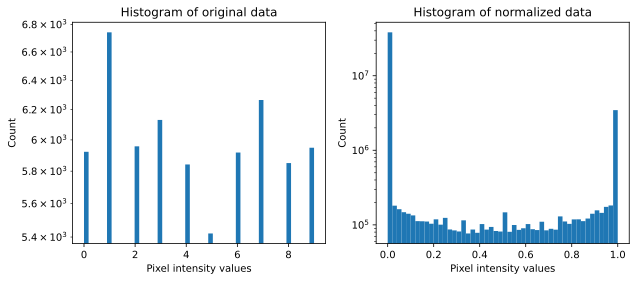

In [4]:
# Plot the data to see the data distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_labels.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(train_data_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

plt.show()

In [5]:
### Create train and test groups using dataloader

dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, train_size=0.9
)


# Convert into pytorch dataset
train_dataT = TensorDataset(train_data, train_labels)
test_dataT = TensorDataset(test_data, test_labels)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)

test_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [6]:
# Create the model function
def createNewMNISTNet(lr=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.output(x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lossFun, optimizer

In [7]:
# Function to train the model
nEpochs = 10


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet()

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append(
            100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
        )
    # End of epoch

    return trainAcc, testAcc, losses, net

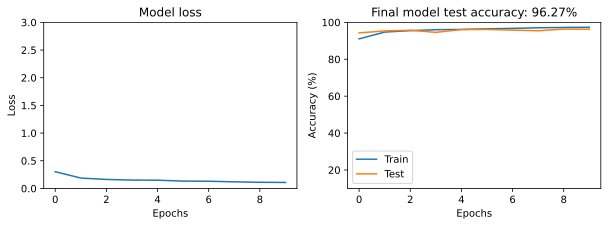

In [8]:
trainAcc, testAcc, losses, net = trainTheModel()

# visualization starts here
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [9]:
#### Compute the performance measures on the train and test data ####
# Predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat, axis=1).cpu()

# Predicted digits for training data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat, axis=1).cpu()

print(train_predictions, test_predictions)

tensor([4, 2, 3,  ..., 8, 2, 5]) tensor([0, 4, 9,  ..., 3, 3, 9])


In [10]:
# Initialize performance matrix
train_matrics = [0, 0, 0, 0]
test_matrics = [0, 0, 0, 0]

# Training
train_matrics[0] = skm.accuracy_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu()
)
train_matrics[1] = skm.precision_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu(), average="weighted"
)
train_matrics[2] = skm.recall_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu(), average="weighted"
)
train_matrics[3] = skm.f1_score(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu(), average="weighted"
)

# Test
test_matrics[0] = skm.accuracy_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu()
)
test_matrics[1] = skm.precision_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu(), average="weighted"
)
test_matrics[2] = skm.recall_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu(), average="weighted"
)
test_matrics[3] = skm.f1_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu(), average="weighted"
)

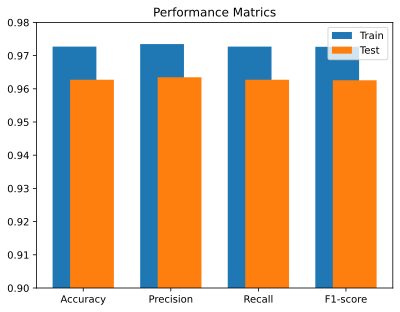

In [11]:
# Bar plots of performance matrices
plt.bar(np.arange(4) - 0.1, train_matrics, 0.5)
plt.bar(np.arange(4) + 0.1, test_matrics, 0.5)
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1-score"])
plt.ylim([0.90, 0.98])
plt.legend(["Train", "Test"])
plt.title("Performance Matrics")
plt.show()

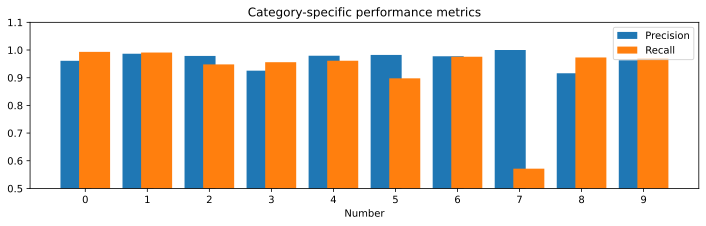

In [18]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu(), average=None
)
recall = skm.recall_score(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu(), average=None
)


fig = plt.figure(figsize=(12, 3))
plt.bar(np.arange(10) - 0.15, precision, 0.5)
plt.bar(np.arange(10) + 0.15, recall, 0.5)
plt.xticks(range(10), range(10))
plt.ylim([0.5, 1.1])
plt.xlabel("Number")
plt.legend(["Precision", "Recall"])
plt.title("Category-specific performance metrics")
plt.show()

In [16]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: [0.96116505 0.98648649 0.97860963 0.92553191 0.97938144 0.98231827
 0.97743056 1.         0.91596639 0.96296296]
Recall: [0.99331104 0.99095023 0.94818653 0.95604396 0.96121417 0.89766607
 0.97573657 0.57142857 0.97321429 0.97077922]


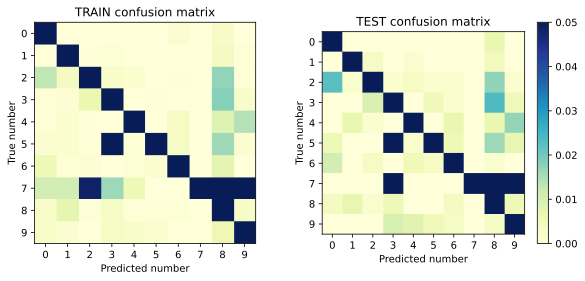

In [17]:
# Confusion matrices
trainConf = skm.confusion_matrix(
    train_loader.dataset.tensors[1].cpu(), train_predictions.cpu(), normalize="true"
)
testConf = skm.confusion_matrix(
    test_loader.dataset.tensors[1].cpu(), test_predictions.cpu(), normalize="true"
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# confmat during TRAIN
ax[0].imshow(trainConf, "YlGnBu", vmax=0.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title("TRAIN confusion matrix")
ax[0].set_xlabel("True number")
ax[0].set_xlabel("Predicted number")
ax[0].set_ylabel("True number")

# confmat during TEST
a = ax[1].imshow(testConf, cmap="YlGnBu", vmax=0.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title("TEST confusion matrix")
ax[1].set_xlabel("Predicted number")
ax[1].set_ylabel("True number")

fig.colorbar(a)
plt.show()